## Step 1: Retrieve Data

In this step, we retrieve data from the IMDB local dataset. The dataset contains movie reviews along with their sentiment labels (positive or negative). To download the dataset, you can use the following URL: "https://drive.google.com/uc?export=download&id=1mZa8RIFAvPBkbjkezKutqrxlhBHkvS7u".  

### **Dataset Description**
The dataset is structured as follows:  
- **review** (*string*): The text of the movie review.  
- **sentiment** (*int*): The sentiment of the review (0 = negative, 1 = positive).  

In [2]:
import pandas as pd

df = pd.read_csv("IMDB Dataset 5000.csv",
                 quoting=1,  # QUOTE_ALL=1, QUOTE_MINIMAL=0, QUOTE_NONE=3, QUOTE_NONNUMERIC=2
                 escapechar='\\',  # Escape character for backslash
                 encoding='utf-8')  # Encoding for the CSV file
# Visualize the first few rows of the DataFrame
print("Print the head of the dataset:")
print(df.head())
print("\n")

# Control the number of positive and negative reviews
print("Control the number of positive and negative reviews:")
print(df['sentiment'].value_counts())

Print the head of the dataset:
                                              review sentiment
0  Why would this film be so good, but only gross...  positive
1  The name "cult movie" is often given to films ...  negative
2  Another stinker from the PM Entertainment grou...  negative
3  It really isn't hard to understand this movie!...  positive
4  Make no mistake, Maureen O'Sullivan is easily ...  positive


Control the number of positive and negative reviews:
sentiment
positive    2500
negative    2500
Name: count, dtype: int64


## Step 2: Split the Dataset into Training and Test Sets

To build and evaluate a machine learning model, we need to split our dataset into:  
- **Training set (80%)**: Used to train the model.  
- **Test set (20%)**: Used to evaluate the model's performance on unseen data.  

We use `train_test_split` from **scikit-learn** to randomly divide the dataset. 

In [3]:
# Divide the original dataset into a training set (80% of the examples) and a test set (20% of the examples).
from sklearn.model_selection import train_test_split

# Divide the dataset into features (X) and target (y)
# X contains the reviews, y contains the sentiment labels (0 for negative, 1 for positive)
X = df['review'].values
# print(X)
y = (df['sentiment'] == 'positive').astype(int).values
# print(y)

# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # arrays to split
    test_size=0.2, # percentage of the dataset to include in the test split
    random_state=42 # random seed for reproducibility
)

# Print the number of reviews in the training and test sets
print(f"Training set: {len(X_train)} reviews")
print(f"Test set: {len(X_test)} reviews")


Training set: 4000 reviews
Test set: 1000 reviews


## Step 3: Define the Sentiment Classification Model

In this step, we define a **simple feedforward neural network** using **PyTorch** to classify movie reviews as **positive** or **negative**.  

### **Neural Network Architecture**
- **Input Layer**: Accepts input features (word embeddings, TF-IDF, etc.).  
- **Hidden Layer**: Applies a **ReLU (Rectified Linear Unit)** activation function.  
- **Output Layer**: Uses a **Sigmoid** activation to produce a probability between 0 and 1 (for binary classification).  

Now, let's define the model using PyTorch.  

In [4]:
# Model definition
# In this example, we will create a simple feedforward neural network for sentiment classification.
import torch
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SentimentClassifier, self).__init__()
        self.input_size = input_size # Number of features in the input data
        self.layer1 = nn.Linear(input_size, hidden_size) # First layer
        self.activation = nn.ReLU() # Activation function (ReLU)
        self.layer2 = nn.Linear(hidden_size, output_size) # Second layer
        self.final_activation = nn.Sigmoid()  # Output between 0 and 1 for binary classification
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.final_activation(x)
        return x

# Visualize the neural network
model = SentimentClassifier(input_size=5, hidden_size=10)
print(model)

SentimentClassifier(
  (layer1): Linear(in_features=5, out_features=10, bias=True)
  (activation): ReLU()
  (layer2): Linear(in_features=10, out_features=1, bias=True)
  (final_activation): Sigmoid()
)


## Step 4: Transform Text Data into Numerical Vectors

Since neural networks cannot process raw text directly, we need to **convert the text reviews into numerical vectors**.  
In this step, we use the **Bag-of-Words (BoW)** model to transform the text into a structured numerical format.

### **Bag-of-Words Model**
- Represents each review as a **vector** where each element corresponds to a word in the vocabulary.
- The value in each position is the **count** of that word in the review.
- Example:  
  - Sentence: *"I love this movie. This movie is great!"*  
  - Bag-of-Words representation: `{'I':1, 'love':1, 'this':2, 'movie':2, 'is':1, 'great':1}`  

Now, let's apply **Bag-of-Words** to our dataset.


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

# Transform the reviews into numerical vectors using Bag-of-Words model (Bag-of-Words: https://en.wikipedia.org/wiki/Bag-of-words_model)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X_train).toarray()

# Print index of the first 10 words in the vocabulary
feature_names = vectorizer.get_feature_names_out()
print("Vocabulary (index → word):")
for idx, word in enumerate(feature_names):
    if(idx < 10 or idx > len(feature_names) - 10):
        print(f"{idx}: {word}")
    if idx == 10:
        print("...")

# Example of visualization of a vectorized review
print("\nOriginal review:", X_train[0])
print("Numeric vector:", X_bow[0])
print("Words inside original reviews:")
for idx, count in enumerate(X_bow[0]):
    if count > 0:
        print(f"  {feature_names[idx]}: {count}")

# Convert in tensors PyTorch
X_tensor = torch.FloatTensor(X_bow)
y_tensor = torch.FloatTensor([1 if s >= 0.5 else 0 for s in y_train])

# Print tensor shapes
print("\nTensors shapes:")
print(f"X: {X_tensor.shape}")
print(f"y: {y_tensor.shape}")

# Personalized Dataset class
class ReviewDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# DataLoader
dataset = ReviewDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

Vocabulary (index → word):
0: 00
1: 000
2: 001
3: 007
4: 00am
5: 00o
6: 00s
7: 01
8: 02
9: 05
...
34804: zwrite
34805: zzzzzzzzzzzz
34806: zzzzzzzzzzzzzzzzzz
34807: zázvorková
34808: émigré
34809: était
34810: óli
34811: über
34812: übermensch

Original review: This is simply a classic film where the human voices coming from the animals are really what they're thoughts are. I don't know whether my video copy has a scene missing but it never shows how the dogs got out of the pit. It also shows an animals survival instinct and tracking abilities.Put humans in the same position ant the helicopters would be out. For once an original film is improved by a remake as the voice-over for the first has been removed. Only the use of animals can work in a film of this kind because using people would have had to spice out the story by turning it into murder,proving that,after all,animals are more interesting than people
Numeric vector: [0 0 0 ... 0 0 0]
Words inside original reviews:
  abilities: 1

## Step 5: Training the Neural Network Model

Now that we have defined our model and transformed the text into numerical vectors, we can train the **feedforward neural network** for sentiment classification.

### **Training Process**
1. **Define Hyperparameters**:  
   - `num_epochs`: Number of times the model will see the entire dataset.  
   - `learning_rate`: Determines how much to adjust weights after each step.  

2. **Define Loss Function and Optimizer**:  
   - **Binary Cross Entropy (BCELoss)** is used because we are dealing with **binary classification**.  
   - **Adam optimizer** is chosen for efficient weight updates.  

3. **Training Loop**:  
   - For each epoch, we iterate over batches of data from the `DataLoader`.  
   - Compute predictions, compare them with actual labels, and calculate the loss.  
   - Perform **backpropagation** to adjust weights.  
   - Track loss for monitoring performance.  


In [ ]:
# Training loop.

import torch.nn as nn
import matplotlib.pyplot as plt

# Model for sentiment analysis (reused from above)
input_size = X_tensor.shape[1]  # Vocabulary size (number of features)
hidden_size = 10
output_size = 1  # Output size for binary classification (0 or 1)
model = SentimentClassifier(input_size, hidden_size, output_size)

# Training parameters
num_epochs = 50
learning_rate = 0.01

# Definition of loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy (for sigmoid output)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# List to keep track of the loss for each epoch
loss_history = []

# Cycle of training
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        targets = targets.view(-1, 1)  # Reshape match with output
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Calculate gradients
        optimizer.step()       # Optimize weights

        running_loss += loss.item()

    # Calculate the average loss for this epoch
    epoch_loss = running_loss / len(dataloader)
    loss_history.append(epoch_loss)

    # Print mean loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: 0.5265
Epoch 2/50, Loss: 0.2610
Epoch 3/50, Loss: 0.1481
Epoch 4/50, Loss: 0.1072
Epoch 5/50, Loss: 0.0925
Epoch 6/50, Loss: 0.0852
Epoch 7/50, Loss: 0.0685
Epoch 8/50, Loss: 0.0741
Epoch 9/50, Loss: 0.0611
Epoch 10/50, Loss: 0.0594
Epoch 11/50, Loss: 0.0598
Epoch 12/50, Loss: 0.0838
Epoch 13/50, Loss: 0.0723
Epoch 14/50, Loss: 0.0669
Epoch 15/50, Loss: 0.0601
Epoch 16/50, Loss: 0.0432
Epoch 17/50, Loss: 0.0363
Epoch 18/50, Loss: 0.0295
Epoch 19/50, Loss: 0.0393
Epoch 20/50, Loss: 0.0268
Epoch 21/50, Loss: 0.0268
Epoch 22/50, Loss: 0.0496
Epoch 23/50, Loss: 0.0200
Epoch 24/50, Loss: 0.0070
Epoch 25/50, Loss: 0.0055
Epoch 26/50, Loss: 0.0474
Epoch 27/50, Loss: 0.0087
Epoch 28/50, Loss: 0.0052
Epoch 29/50, Loss: 0.0015
Epoch 30/50, Loss: 0.0627
Epoch 31/50, Loss: 0.0186
Epoch 32/50, Loss: 0.0012
Epoch 33/50, Loss: 0.0012
Epoch 34/50, Loss: 0.0012
Epoch 35/50, Loss: 0.0012
Epoch 36/50, Loss: 0.0012
Epoch 37/50, Loss: 0.0012
Epoch 38/50, Loss: 0.0012
Epoch 39/50, Loss: 0.

## Step 6: Visualizing the Training Loss

To monitor the learning process, we **plot the loss** recorded at each epoch.  
This helps us understand:
- **If the model is learning properly** (loss should decrease over time).  
- **If there are issues like overfitting** (loss stagnation or sudden increases).  

The loss curve provides insight into whether we need to **adjust hyperparameters** (e.g., learning rate, epochs).  


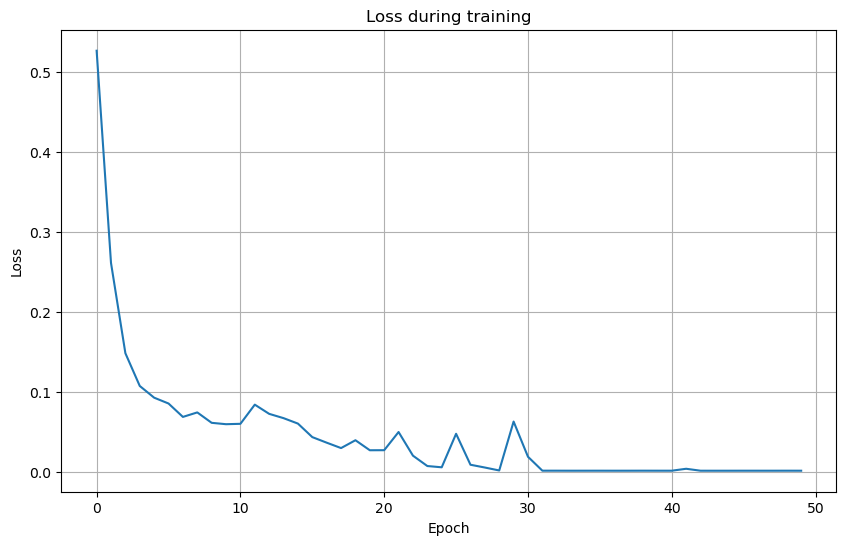

In [7]:
# Plot loss for each epoch
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title("Loss during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Step 7: Evaluate the Model on the Test Set and Make Predictions

Once training is complete, we can evaluate the model on **unseen data** to test its performance.  
In this step, we also demonstrate how to use the trained model for making predictions on **new, unseen reviews**.

### **Steps:**
1. **Set the model to evaluation mode**:  
   - `model.eval()` tells the model that we are in evaluation mode, so dropout layers (if any) are disabled, and the model doesn't update weights.

2. **Make Predictions**:
   - Preprocess the new review (convert text to vector).  
   - Feed the processed input to the model and obtain the output.  
   - If the output is greater than or equal to 0.5, the review is predicted as **positive**. Otherwise, it's **negative**.  
   - Confidence is the output probability (closer to 1 means higher confidence).

Let's now see the code for making predictions on a new review.


In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    # Prediction on new review
    new_review = "This film was fantastic and moving"

    # Preprocessing
    new_review_vec = vectorizer.transform([new_review]).toarray()
    new_review_tensor = torch.FloatTensor(new_review_vec)

    # Prediction
    output = model(new_review_tensor)
    prediction = "Positive" if output.item() >= 0.5 else "Negative"
    confidence = output.item() if output.item() >= 0.5 else 1 - output.item()

    print(f"Review: '{new_review}'")
    print(f"Prediction: {prediction} (confidence: {confidence:.4f})")

## Step 8: Evaluate the Model on the Test Set

After training, we need to evaluate the model's performance on the **test set** to check how well it generalizes to unseen data.

### **Steps:**
1. **Evaluation Mode**: 
   - The model is set to **evaluation mode** using `model.eval()` to disable behaviors like dropout and batch normalization (which are only active during training).

2. **Forward Pass**:
   - The **test data** is passed through the model to get predictions.

3. **Accuracy Calculation**:
   - Predictions are compared to the true labels to calculate the accuracy.
   - Accuracy is the proportion of correctly predicted labels out of all the samples.

4. **Final Output**: 
   - The model's accuracy is printed, showing how well the model performed on the test data.

Let's now examine the Python code for evaluating the model.


In [ ]:
def evaluate_model(model, test_loader):
    """Model evaluation."""
    model.eval()  # Evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in test_loader:
            # 1. Forward pass
            outputs = model(inputs)

            # 2. Convert the output in predictions (0 or 1)
            predictions = (outputs >= 0.5).int()

            # 3. Compare predictions with labels
            total += labels.size(0)
            correct += (predictions.squeeze() == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")

# Loop for evaluation
X_test_bow = vectorizer.transform(X_test).toarray()
X_test_tensor = torch.FloatTensor(X_test_bow)
y_test_tensor = torch.FloatTensor([1 if s >= 0.5 else 0 for s in y_test])

test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

evaluate_model(model, test_loader)